In [49]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from scipy.spatial import distance
from sklearn.preprocessing import normalize
from PIL import Image
from scipy.spatial.distance import cdist # 创建函数来查找测试图像的最近邻
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # 取消大小限制


In [50]:
# 加载不同的 CSV 文件
try:
    style_data = pd.read_csv('wikiart_csv/Style_train.csv', header=None)
    style_data.columns = ['image_path', 'class_index']
    
    artist_data = pd.read_csv('wikiart_csv/Artist_train.csv', header=None)
    artist_data.columns = ['image_path', 'class_index']
    
    genre_data = pd.read_csv('wikiart_csv/Genre_train.csv', header=None)
    genre_data.columns = ['image_path', 'class_index']
    
    # 查看数据的前几行
    print("成功加载 CSV 文件！")
    print(style_data.head())
    print(artist_data.head())
    print(genre_data.head())
except FileNotFoundError as e:
    print(f"找不到 CSV 文件: {e}")
except pd.errors.EmptyDataError:
    print("CSV 文件为空！")
except pd.errors.ParserError:
    print("CSV 文件解析错误！")


成功加载 CSV 文件！
                                          image_path  class_index
0  Impressionism/edgar-degas_landscape-on-the-orn...           12
1         Realism/camille-corot_mantes-cathedral.jpg           21
2  Abstract_Expressionism/gene-davis_untitled-197...            0
3      Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg           24
4  Impressionism/maurice-prendergast_paris-boulev...           12
                                          image_path  class_index
0  Realism/vincent-van-gogh_pine-trees-in-the-fen...           22
1  Baroque/rembrandt_the-angel-appearing-to-the-s...           20
2  Post_Impressionism/paul-cezanne_portrait-of-th...           16
3  Impressionism/pierre-auguste-renoir_young-girl...           17
4       Romanticism/ivan-aivazovsky_morning-1851.jpg            9
                                          image_path  class_index
0  Northern_Renaissance/hieronymus-bosch_st-jacqu...            7
1  Post_Impressionism/vincent-van-gogh_ears-of-wh...           

In [51]:
data_dir = 'wikiart'  # 数据目录
if not os.path.exists(data_dir):
    print(f"数据目录不存在: {data_dir}")
else:
    print(f"数据目录存在: {data_dir}")


数据目录存在: wikiart


In [52]:
# 调整图像大小
img_size = (128, 128)  
batch_size = 50

In [53]:
class ImageLabelGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_frame, data_dir, batch_size, img_size, shuffle=True, num_classes=10):
        self.data_frame = data_frame
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes  
        self.indexes = np.arange(len(self.data_frame))

    def __len__(self):
        return int(np.floor(len(self.data_frame) / self.batch_size))
    
    def __getitem__(self, index):
        max_attempts = 3  # 最多尝试 3 次
        attempts = 0
    
        while attempts < max_attempts:
            batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
            batch_images = []
            batch_labels = []
        
            for i in batch_indexes:
                img_path = os.path.join(self.data_dir, self.data_frame.iloc[i, 0])
                try:
                    img = load_img(img_path, target_size=self.img_size)
                    img = img_to_array(img) / 255.0  # 归一化
                    label = self.data_frame.iloc[i, 1]  # 正确获取标签
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue  # 跳过无法加载的图像
                batch_images.append(img)
                batch_labels.append(label)
        
            # 如果有有效的图像，返回批次数据
            if len(batch_images) > 0:
                return np.array(batch_images), to_categorical(np.array(batch_labels), num_classes=self.num_classes)
        
            attempts += 1
            print(f"尝试加载失败，重新尝试第 {attempts} 次...")
        
        # 如果连续几次都失败，则抛出异常
        raise ValueError("连续几次尝试后仍无法加载有效数据，请检查数据路径和格式！")


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            print("已打乱数据顺序")

In [54]:
# 使用生成器加载训练数据和验证数据
num_classes = len(style_data['class_index'].unique())
train_gen = ImageLabelGenerator(style_data, data_dir, batch_size, img_size, shuffle=True, num_classes=num_classes)
val_gen = ImageLabelGenerator(style_data, data_dir, batch_size, img_size, shuffle=False, num_classes=num_classes)


# 查看数据
print("Number of classes:", num_classes)
print("Batch size:", batch_size)

Number of classes: 27
Batch size: 50


In [55]:
# Check value for image pixel 
# Notice that they already within 0-255
image_batch_original, labels_batch_original = next(iter(train_gen))
first_image = image_batch_original[0]

print("The shape for original image batch is", image_batch_original.shape,
     "\nThis means that there are",image_batch_original.shape[0],"images in a training batch,",
      "with size of",image_batch_original.shape[1],"by",image_batch_original.shape[2] )

print("\nUse the 1st image inside the training batch as an example.",
      "\nThe shape for original label batch is", labels_batch_original.shape,
       "\nThe minimum value for original pixel is", np.min(first_image),
       "\nThe maximum value for original pixel is", np.max(first_image),
       "\nThe mean value for original pixel is", np.mean(first_image),
       "\nThe standard derivative value for original pixel is", np.std(first_image))

The shape for original image batch is (50, 128, 128, 3) 
This means that there are 50 images in a training batch, with size of 128 by 128

Use the 1st image inside the training batch as an example. 
The shape for original label batch is (50, 27) 
The minimum value for original pixel is 0.0 
The maximum value for original pixel is 1.0 
The mean value for original pixel is 0.4173235 
The standard derivative value for original pixel is 0.25249636


### ConvLSTM
- 卷积部分 (Conv2D): 提取图像的空间特征。
- LSTM 部分: 图像的局部特征序列

In [56]:
# # 自定义生成器，扩展时间步维度
# def add_time_step_dimension(generator):
#     for images, labels in generator:
#         # 增加时间步维度: (batch_size, 128, 128, 3) -> (batch_size, 1, 128, 128, 3)
#         images = np.expand_dims(images, axis=1)
#         yield images, labels

def add_time_step_dimension(generator):
    yield from ((np.expand_dims(images, axis=1), labels) for images, labels in generator)


train_gen = add_time_step_dimension(train_gen)
val_gen = add_time_step_dimension(val_gen)

# 创建 ConvLSTM 模型
model = Sequential()

# ConvLSTM2D 层
time_steps = 1
input_shape = (time_steps, img_size[0], img_size[1], 3)
model.add(ConvLSTM2D(filters=32, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=input_shape, 
                    return_sequences=False))

# model.add(ConvLSTM2D(filters=32, 
#                     kernel_size=(3, 3), 
#                     activation='relu',
#                     input_shape=(1, img_size[0], img_size[1], 3),  # 使用明确的时间步 (1)
#                     return_sequences=False))
model.add(BatchNormalization())

# 卷积层
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout
model.add(Dropout(0.3))

# 展平层
model.add(Flatten())  # 全连接层
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# 输出层
model.add(Dense(num_classes, activation='softmax', 
                kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 126, 126, 32)   │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 126, 126, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 59, 59, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,099,995 (53.79 MB)

 Trainable params: 14,099,931 (53.79 MB)

 Non-trainable params: 64 (256.00 B)

In [57]:

# train_sample_count = tf.data.experimental.cardinality(train_gen).numpy()
# val_sample_count = tf.data.experimental.cardinality(val_gen).numpy()

train_sample_count = len(style_data)
val_sample_count = len(style_data)

print("训练集样本数:", train_sample_count)
print("验证集样本数:", val_sample_count)

# 计算样本总数
# train_sample_count = len(style_data)
# val_sample_count = len(style_data)

# steps_per_epoch = len(train_gen)
# validation_steps = len(val_gen)

steps_per_epoch = int(np.ceil(train_sample_count / batch_size))
validation_steps = int(np.ceil(val_sample_count / batch_size))

# steps_per_epoch = int(np.ceil(len(train_gen) / batch_size))  # 向上取整
# validation_steps = int(np.ceil(len(val_gen) / batch_size))


print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

# 训练模型
history = model.fit(
    train_gen,
    epochs=2,
    validation_data=val_gen,
    steps_per_epoch=2,  # 每个epoch只执行2步
    validation_steps=2  # 验证集也只执行2步
    #steps_per_epoch=steps_per_epoch,
    #validation_steps=validation_steps
)



训练集样本数: 57025
验证集样本数: 57025
steps_per_epoch: 1141
validation_steps: 1141
Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0733 - loss: 7.8092 - val_accuracy: 0.1000 - val_loss: 7.1282
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 927ms/step - accuracy: 0.0600 - loss: 7.2138 - val_accuracy: 0.1100 - val_loss: 7.0825


In [58]:
validation_steps = 2 # just to make model run, will change later
test_loss, test_accuracy = model.evaluate(val_gen, steps=validation_steps)
print(f'验证集损失: {test_loss}, 验证集准确率: {test_accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.0200 - loss: 7.0837
验证集损失: 7.083438873291016, 验证集准确率: 0.019999999552965164


In [59]:
# 获取预测结果
validation_steps = 2 # just to make model run, will change later
y_pred = model.predict(val_gen, steps=validation_steps)  # 设置steps确保生成器不会提前结束

# 将预测结果转换为类别标签
y_pred_classes = np.argmax(y_pred, axis=1)

# 获取真实标签
y_true = []

# 遍历验证集生成器，提取标签
for _, labels in add_time_step_dimension(val_gen):
    # 由于 labels 经过时间步维度的扩展，取第一个维度（时间步）然后求最大值获取类别标签
    y_true.extend(np.argmax(labels, axis=1))

# 将真实标签转换为 NumPy 数组
y_true = np.array(y_true)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Error loading image wikiart/Baroque/rembrandt_woman-standing-with-raised-hands.jpg: [Errno 2] No such file or directory: 'wikiart/Baroque/rembrandt_woman-standing-with-raised-hands.jpg'
Error loading image wikiart/Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg: [Errno 2] No such file or directory: 'wikiart/Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg'


In [60]:
# 分类报告
#print(classification_report(y_true, y_pred_classes, target_names=list(val_gen.class_indices.keys())))

AttributeError: 'generator' object has no attribute 'class_indices'

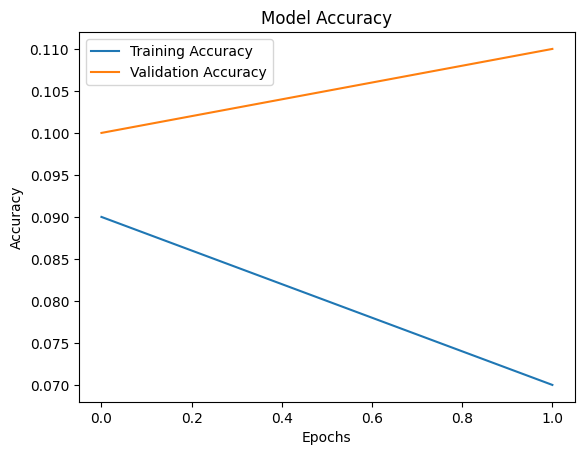

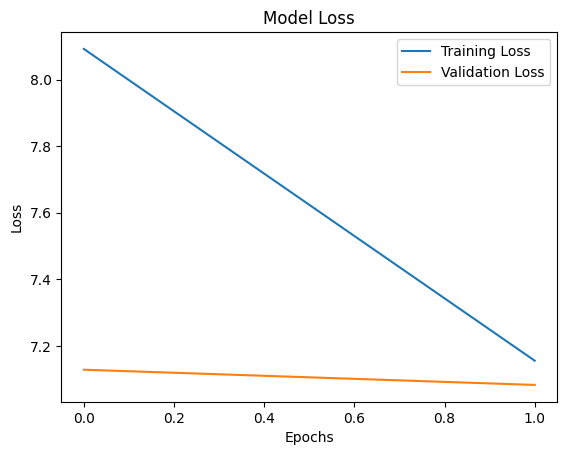

In [61]:
# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [69]:
# # 绘制混淆矩阵
# cm = confusion_matrix(y_true, y_pred_classes)
class_indices = {v: k for k, v in enumerate(style_data['class_index'].unique())}
class_names = list(class_indices.keys())

# cm_df = pd.DataFrame(cm, index=class_names, columns=list(val_gen.class_indices.keys()))


In [67]:
# cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('True Labels')
# plt.xlabel('Predicted Labels')
# plt.show()


In [77]:
# 获取整个验证集的预测结果
y_pred_classes = []
y_true = []

# 对验证集进行预测
for batch_images, batch_labels in val_gen:
    # 获取预测结果
    batch_preds = model.predict(batch_images)
    batch_preds_classes = np.argmax(batch_preds, axis=1)
    
    # 获取真实标签
    batch_labels_classes = np.argmax(batch_labels, axis=1)
    
    # 将批次结果添加到列表中
    y_pred_classes.extend(batch_preds_classes)
    y_true.extend(batch_labels_classes)

# 转换为 NumPy 数组
y_pred_classes = np.array(y_pred_classes)
y_true = np.array(y_true)

# 查找错误分类的样本
incorrect_idx = np.where(y_pred_classes != y_true)[0]

# 查看前 5 个错误分类的图像
for idx in incorrect_idx[:5]:
    img_path = os.path.join(data_dir, style_data.iloc[idx]['image_path'])
    img = load_img(img_path, target_size=img_size)
    plt.imshow(img)
    true_label = class_names[y_true[idx]]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    plt.pause(0.1)  # 让显示过程有一个小的延迟，确保图像渲染

In [76]:
# 进行一次预测以确保模型的输入已被初始化
_ = model.predict(train_gen, batch_size=batch_size)

# 确保层名称正确
print("Model Layers:")
for layer in model.layers:
    print(layer.name)

# 提取中间层的特征
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_3').output)

# 提取训练集和验证集的特征
train_features = feature_extractor.predict(train_gen, batch_size=batch_size)
val_features = feature_extractor.predict(val_gen, batch_size=batch_size)

# 标准化特征
train_features = normalize(train_features.reshape(train_features.shape[0], -1))  # 扁平化并标准化
val_features = normalize(val_features.reshape(val_features.shape[0], -1))

# 存储文件名以便后续可视化
train_filenames = train_gen.filenames
val_filenames = val_gen.filenames

def pictures(test_idx):
    test_feature = val_features[test_idx].reshape(1, -1)
    my_distance = cdist(test_feature, train_features, metric='euclidean')[0]
    nearest_neighbors_idx = np.argpartition(my_distance, 5)[:5]
    
    plt.figure(figsize=(8, 8))     
    plt.subplot(2, 3, 1)
    img = plt.imread(os.path.join(data_dir, style_data.iloc[test_idx]['image_path']))
    plt.imshow(img)
    plt.title(f"Test Image: {style_data.iloc[test_idx]['image_path']}")
    plt.axis('off')
    
    for p in range(len(nearest_neighbors_idx)):
        plt.subplot(2, 3, p + 2)
        neighbor_image = plt.imread(os.path.join(data_dir, style_data.iloc[nearest_neighbors_idx[p]]['image_path']))
        plt.imshow(neighbor_image)
        plt.title(f"Neighbor {p+1}")
        plt.axis('off')
    
    plt.show()


    760/Unknown 281s 369ms/stepError loading image wikiart/Baroque/rembrandt_woman-standing-with-raised-hands.jpg: [Errno 2] No such file or directory: 'wikiart/Baroque/rembrandt_woman-standing-with-raised-hands.jpg'


KeyboardInterrupt: 

In [ ]:
# # 保存模型
# model.save('WikiArt_CNN_LSTM.h5')

# # 加载模型
# from tensorflow.keras.models import load_model
# model = load_model('WikiArt_CNN_LSTM.h5')
